In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
import time

from keras import backend as K

from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Dropout, Flatten, Input, Lambda, Reshape)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/xiafei/opt/anaconda3/lib/python3.7

# Get top features from itu project 
https://github.com/xiafei571/itu-ml-challenge

In [2]:
top_feature_df = pd.read_csv('/Users/xiafei/code/itu-ml-challenge/feature_important_data_XG_2021.csv')

In [3]:
xg_top_feature = top_feature_df['var'].values[0:52].tolist()

In [4]:
xg_top_feature

['n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes',
 'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/current-prefixes',
 'v_/ports#link-tr-ssm-b-1-y/metrics/network-outgoing-bytes',
 'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries',
 'v_/ports#link-intgw-exgw-a-3-x/metrics/network-outgoing-bytes-rate',
 'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/total-entries',
 'v_/devices#RR-01/power_state',
 'n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/drop-pkts',
 'v_/ports#link-tr-intgw-a-3-x/metrics/network-incoming-bytes',
 'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/explicit-withdraw',
 'p_/computes0/metrics/compute-node/compute-node-c

In [5]:
xg_top_feature.remove('n_nexthop')
xg_top_feature.remove('Unnamed: 0.1')

In [6]:
print(len(xg_top_feature))

50


In [7]:
df = pd.read_csv('/Users/xiafei/code/itu-ml-challenge/csv/dataset.csv')

In [8]:
print(df.shape)
df.head()

(9670, 1000)


,Unnamed: 0,p_/computes0/service/id,p_/computes0/vcpus_used,p_/computes0/local_gb_used,p_/computes0/vcpus,p_/computes0/memory_mb_used,p_/computes0/memory_mb,p_/computes0/current_workload,p_/computes0/cpu_info/topology/cores,p_/computes0/cpu_info/topology/cells,...,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-drop,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-error,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-rate,v_/time,v_type,v_type_code
0,0,16,20,0,48,41472,257790,0,12,2,...,0.100425,174853276.0,11.431817,1263588.0,0.0,0.0,0.099783,1593395580,ixnetwork-traffic-start,0
1,1,16,20,0,48,41472,257790,0,12,2,...,0.099506,174854074.0,13.313681,1263595.0,0.0,0.0,0.116705,1593395640,ixnetwork-traffic-start,0
2,2,16,20,0,48,41472,257790,0,12,2,...,0.099506,174854758.0,13.313681,1263601.0,0.0,0.0,0.100463,1593395700,ixnetwork-traffic-start,0
3,3,16,20,0,48,41472,257790,0,12,2,...,0.099826,174855556.0,13.277844,1263608.0,0.0,0.0,0.116223,1593395760,ixnetwork-traffic-start,0
4,4,16,20,0,48,41472,257790,0,12,2,...,0.116494,174856338.0,13.277844,1263615.0,0.0,0.0,0.116614,1593395820,ixnetwork-traffic-start,0


# delete zero colums

In [9]:
df = df.loc[:,(df !=0).any(axis=0)]

In [10]:
print(df.shape)
df.head()

(9670, 663)


,Unnamed: 0,p_/computes0/service/id,p_/computes0/vcpus_used,p_/computes0/vcpus,p_/computes0/memory_mb_used,p_/computes0/memory_mb,p_/computes0/cpu_info/topology/cores,p_/computes0/cpu_info/topology/cells,p_/computes0/cpu_info/topology/threads,p_/computes0/cpu_info/topology/sockets,...,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-rate,v_/time,v_type,v_type_code
0,0,16,20,48,41472,257790,12,2,2,1,...,13.236069,1401532.0,0.100425,174853276.0,11.431817,1263588.0,0.099783,1593395580,ixnetwork-traffic-start,0
1,1,16,20,48,41472,257790,12,2,2,1,...,11.438221,1401538.0,0.099506,174854074.0,13.313681,1263595.0,0.116705,1593395640,ixnetwork-traffic-start,0
2,2,16,20,48,41472,257790,12,2,2,1,...,11.438221,1401545.0,0.099506,174854758.0,13.313681,1263601.0,0.100463,1593395700,ixnetwork-traffic-start,0
3,3,16,20,48,41472,257790,12,2,2,1,...,11.429972,1401551.0,0.099826,174855556.0,13.277844,1263608.0,0.116223,1593395760,ixnetwork-traffic-start,0
4,4,16,20,48,41472,257790,12,2,2,1,...,11.429972,1401558.0,0.116494,174856338.0,13.277844,1263615.0,0.116614,1593395820,ixnetwork-traffic-start,0


In [11]:
# df_type12 = df[(df['v_type_code'] == 1)|(df['v_type_code'] == 2)]

In [12]:
# df_type12.head(10)

# select type n as the original data

In [13]:
curr_type = 9

In [14]:
df_typeN = df[df['v_type_code'] == curr_type]
print(df_typeN.shape)

(456, 663)


# generate datetime_file list

In [15]:
timestamp_list = df_typeN['v_/time'].values.tolist()

In [16]:
file_list = []
for timestamp in timestamp_list:
    file_name = time.strftime("%Y%m%d%H%M", time.localtime(int(timestamp)))
    file_list.append(file_name + '00.json')
print(len(file_list))

456


In [17]:
# save top N
top_N = 455
file_list = file_list[:top_N-5]

In [18]:
line = 0
w = open("./type"+str(curr_type)+"time_processed.txt","wt")
for file_name in file_list:
    w.write(file_name + '\n')
    line = line + 1
    if line % 10 == 0:
        print(line, end=',')
w.close()

10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,

# delete unused columns

In [19]:
df_typeN = df_typeN.reset_index(drop=True)

In [20]:
df_typeN = df_typeN[:top_N]

In [21]:
df_typeN.shape

(455, 663)

In [22]:
df_typeN = df_typeN.drop(columns=['Unnamed: 0'])

In [23]:
len(xg_top_feature)

50

In [24]:
df_typeN = df_typeN[xg_top_feature]
print(df_typeN.shape)
df_typeN.head()

(455, 50)


,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/current-prefixes,v_/ports#link-tr-ssm-b-1-y/metrics/network-outgoing-bytes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries,v_/ports#link-intgw-exgw-a-3-x/metrics/network-outgoing-bytes-rate,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/total-entries,v_/devices#RR-01/power_state,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/drop-pkts,v_/ports#link-tr-intgw-a-3-x/metrics/network-incoming-bytes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/explicit-withdraw,...,n_/devices/modules/Cisco-IOS-XE-memory-oper/memory-statistics/memory-statistic/used-memory,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-table-version,v_/devices#IntGW-02/metrics/disk-device-write-bytes-rate,v_/ports#link-tr-intgw-b-3-x/metrics/network-incoming-bytes,v_/devices#IntGW-01/metrics/cpu_util,v_/ports#link-tr-intgw-a-1-x/metrics/network-incoming-bytes-rate,v_/ports#link-intgw-exgw-b-3-x/metrics/network-outgoing-bytes,v_/ports#IntGW-02/metrics/network-incoming-packets,v_/ports#link-intgw-exgw-a-3-x/metrics/network-outgoing-bytes,v_/ports#link-intgw-exgw-b-3-x/metrics/network-outgoing-bytes-rate
0,1663801,7874,1.430371e+13,4677,1.213604e+06,7874,1,54999500,174412028.0,0,...,359353848,859528,0.000000,178800287.0,63.746543,2.857277e+06,3.439740e+12,221840153.0,3.474749e+12,1.207596e+06
1,1663801,7874,1.430404e+13,4677,1.213604e+06,7874,1,55011817,174412880.0,0,...,359353848,859528,0.000000,178801393.0,62.477080,2.789547e+06,3.439813e+12,221842301.0,3.474822e+12,1.212097e+06
2,1663801,7874,1.430437e+13,4677,1.215628e+06,7874,1,55024164,174413756.0,0,...,359353848,859528,443.907656,178802429.0,63.604223,2.815837e+06,3.439885e+12,221844380.0,3.474895e+12,1.211240e+06
3,1663801,7874,1.430471e+13,4677,1.218147e+06,7874,1,55036583,174414440.0,0,...,359353848,859528,0.000000,178803481.0,62.736540,2.841766e+06,3.439958e+12,221846492.0,3.474968e+12,1.211240e+06
4,1663801,7874,1.430504e+13,4677,1.222134e+06,7874,1,55048989,174415316.0,0,...,359357320,859528,0.000000,178804619.0,62.960869,2.791498e+06,3.440031e+12,221848624.0,3.475041e+12,1.217644e+06


# Save to CSV

In [25]:
df_typeN.to_csv('./data/stock_data.csv', index=False)

# GAN Demo

array([[<AxesSubplot:title={'center':'v_type_code'}>]], dtype=object)

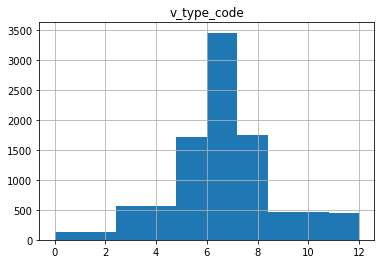

In [88]:
df.hist('v_type_code')

- 0: ixnetwork-traffic-start
- 1: node-down
- 2: node-up
- 3: interface-down
- 4: interface-up
- 5: tap-loss-start
- 6: tap-loss-stop
- 7: tap-delay-start
- 8: tap-delay-stop
- 9: ixnetwork-bgp-injection-start
- 10: ixnetwork-bgp-injection-stop
- 11: ixnetwork-bgp-hijacking-start
- 12: ixnetwork-bgp-hijacking-stop
- 13: ixnetwork-traffic-stop

In [9]:
rf_top_feature = ['n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/total-memory',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/current-prefixes',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/memory-usage',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/path/total-entries',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/total-entries',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/table-version',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-table-version',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/routing-table-version',
       'n_/devices/modules/Cisco-IOS-XE-memory-oper/memory-statistics/memory-statistic/used-memory',
       'n_/devices/modules/Cisco-IOS-XE-memory-oper/memory-statistics/memory-statistic/free-memory',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/bgp-neighbor-counters/sent/updates',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/path/memory-usage',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/total-prefixes',
       'v_/ports#link-tr-intgw-a-1-y/metrics/network-outgoing-packets',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/messages-sent',
       'v_/ports#link-tr-ssm-b-1-y/metrics/network-outgoing-bytes-rate',
       'v_/ports#link-intgw-exgw-a-3-x/metrics/network-outgoing-packets-rate',
       'n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/classifier-entry-stats/classified-bytes',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries',
       'n_prefix',
       'v_/ports#link-intgw-exgw-b-2-x/metrics/network-outgoing-packets-rate',
       'v_/ports#link-tr-intgw-b-2-y/metrics/network-outgoing-bytes',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/memory-usage',
       'v_/ports#link-tr-intgw-a-3-y/metrics/network-incoming-bytes',
       'v_/ports#link-intgw-exgw-a-1-x/metrics/network-outgoing-bytes-rate',
       'v_/ports#link-intgw-exgw-b-1-x/metrics/network-outgoing-packets-rate',
       'v_/ports#TR-01/metrics/network-outgoing-packets',
       'v_/devices#IntGW-01/metrics/cpu_util',
       'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/paths']
print(len(rf_top_feature))

30


In [25]:
xg_top_feature = ['n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes',
'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/current-prefixes',
'v_/ports#link-tr-ssm-b-1-y/metrics/network-outgoing-bytes',
'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries',
'v_/ports#link-intgw-exgw-a-3-x/metrics/network-outgoing-bytes-rate',
'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/total-entries',
'v_/devices#RR-01/power_state',
'n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/drop-pkts',
'v_/ports#link-tr-intgw-a-3-x/metrics/network-incoming-bytes',
'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/explicit-withdraw',
'p_/computes0/metrics/compute-node/compute-node-cpu-idle-percent',
'v_/ports#TR-02/metrics/network-outgoing-packets',
'v_/ports#TR-01/metrics/network-outgoing-packets',
'v_/ports#link-intgw-exgw-b-1-x/metrics/network-outgoing-bytes-rate',
'v_/ports#link-tr-intgw-a-2-x/metrics/network-outgoing-bytes',
'n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/statistics/tx-pps',
'v_/ports#link-tr-intgw-b-2-x/metrics/network-outgoing-bytes',
'n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/classifier-entry-stats/classified-pkts',
'n_nexthop',
'v_/ports#link-intgw-exgw-a-1-x/metrics/network-outgoing-bytes-rate',
'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/implicit-withdraw',
'v_/ports#IntGW-02/metrics/network-incoming-bytes',
'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/bgp-neighbor-counters/sent/updates',
'v_/ports#link-tr-intgw-a-3-x/metrics/network-outgoing-bytes-rate',
'v_/devices#TR-02/metrics/disk-write-requests',
'v_/ports#link-tr-intgw-b-3-y/metrics/network-outgoing-packets-rate']
print(len(xg_top_feature))

26


# GAN

In [81]:
# input traffic dimensions
traf_rows = 5
traf_cols = 10 #996
channels = 1
traf_shape = (traf_rows, traf_cols,channels)

mid_layer = 100

# Size of the noise vector, used as input to the Generator
z_dim = 10

In [82]:
class Dataset:
    def __init__(self, num_labeled, df, train_size):

        # Number labeled examples to use for training
        self.num_labeled = num_labeled        
        self.columns = df.columns
        
        X_all = df[self.columns[1:-3]]
#         X_all = X_all.set_index('v_/time', drop = True, append = True)
        X = X_all[xg_top_10]
        Y = df[self.columns[-1]]
        
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, Y, train_size=train_size, shuffle=False);

        # Normalization
        self.ss = StandardScaler()
#         self.ss = MinMaxScaler() # [0-1]
        self.x_train = self.ss.fit_transform(self.x_train)
        self.x_test = self.ss.fit_transform(self.x_test)
        
        print('x_train:', self.x_train.shape)
        print('x_test:', self.x_test.shape)
        print('x_train:', self.x_train.shape)
        print('x_test:', self.x_test.shape)
        

        def preprocess_trafs(x):
            print('reshape', x.shape,'to',traf_rows, traf_cols)
#             x = x.values.reshape(-1, traf_rows, traf_cols, 1)
            x = x.reshape(-1, traf_rows, traf_cols, 1)
            return x

        def preprocess_labels(y):
            return y.values[::5].reshape(-1, 1)

        # Training data
        self.x_train = preprocess_trafs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)

        # Testing data
        self.x_test = preprocess_trafs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)
        
        print('processed:')
        print(self.x_train.shape)
        print(self.y_train.shape)
        print(self.x_test.shape)
        print(self.y_test.shape)

    def batch_labeled(self, batch_size):
        # Get a random batch of labeled images and their labels
#         idx = np.random.randint(0, self.num_labeled, batch_size)
        rd = np.random.randint(0, self.num_labeled// 5 // batch_size)
        idx = np.arange(rd * batch_size, (rd+1) * batch_size)
        
        trafs = self.x_train[idx]
        labels = self.y_train[idx]
        return trafs, labels

    def batch_unlabeled(self, batch_size):
        # Get a random batch of unlabeled images
        idx = np.random.randint(0, self.x_train.shape[0],
                                batch_size)
        trafs = self.x_train[idx]
        return trafs

    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train

    def test_set(self):
        return self.x_test, self.y_test

In [83]:
# Load dataset
df = pd.read_csv('/Users/xiafei/code/itu-ml-challenge/csv/dataset.csv')
        
# delete zero columns
df = df.loc[:,(df !=0).any(axis=0)]

# df_type12 = df[(df['v_type_code'] == 5)|(df['v_type_code'] == 6)|(df['v_type_code'] == 7)|(df['v_type_code'] == 8)]
df_type3 = df[df['v_type_code'] == 3]

print(df_type3.shape)

(559, 663)


In [84]:
# Number of train data
train_size = 400

# Number of labeled examples to use (rest will be used as unlabeled)
num_labeled = 300

#some times we need cut
df_type3 = df_type3[:555]

In [85]:
dataset = Dataset(num_labeled, df_type3, train_size)

x_train: (400, 10)
x_test: (155, 10)
x_train: (400, 10)
x_test: (155, 10)
reshape (400, 10) to 5 10
reshape (155, 10) to 5 10
processed:
(80, 5, 10, 1)
(80, 1)
(31, 5, 10, 1)
(31, 1)


## Generator

In [86]:
def build_generator(traf_shape, z_dim):

    model = Sequential()

    # Fully connected layer
    model.add(Dense(mid_layer, input_dim=z_dim))
    
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(traf_rows*traf_cols*channels, activation='tanh'))

    # Reshape the Generator output to image dimensions
    model.add(Reshape(traf_shape))

    return model

## Discriminator

In [87]:
def build_discriminator_net(traf_shape):

    model = Sequential()

    # Flatten the input image
    model.add(Flatten(input_shape=traf_shape))

    # Fully connected layer
    model.add(Dense(mid_layer))
    
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Dense(num_classes))
    #model.add(Dense(num_classes, activation='sigmoid'))

    return model

In [88]:
def build_discriminator_supervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    # Softmax activation, giving predicted probability distribution over the real classes
    model.add(Activation('softmax'))

    return model

In [89]:
def build_discriminator_unsupervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    def predict(x):
        # Transform distribution over real classes into a binary real-vs-fake probability
        prediction = 1.0 - (1.0 /
                            (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction

    # 'Real-vs-fake' output neuron defined above
    model.add(Lambda(predict))

    return model

## Build the Model

In [90]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [99]:
num_classes = 4

In [100]:
# Core Discriminator network:
# These layers are shared during supervised and unsupervised training
discriminator_net = build_discriminator_net(traf_shape)

# Build & compile the Discriminator for supervised training
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy',
                                 metrics=['accuracy'],
                                 optimizer=Adam())

# Build & compile the Discriminator for unsupervised training
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy',
                                   optimizer=Adam())

# Build the Generator
generator = build_generator(traf_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator_unsupervised.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
# Note that we are using the Discriminator version with unsupervised output
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## Training

In [101]:
supervised_losses = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        trafs, batch_labels = dataset.batch_labeled(batch_size)
        labels = to_categorical(batch_labels, num_classes=num_classes)
        trafs_unlabeled = dataset.batch_unlabeled(batch_size)
        
        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_trafs = generator.predict(z)

        # Train Discriminator
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(trafs, labels)
        d_loss_real = discriminator_unsupervised.train_on_batch(trafs_unlabeled, real)
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_trafs, fake)
        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_trafs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))

        if (iteration + 1) % sample_interval == 0:
            # Save losses and accuracies so they can be plotted after training
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print(
                "%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                % (iteration + 1, d_loss_supervised, 100 * accuracy,
                   d_loss_unsupervised, g_loss))
            
            
            print(gen_trafs.shape)
            rs_gen_trafs = gen_trafs.reshape(traf_rows * batch_size, traf_cols)
            rs_gen_trafs = dataset.ss.inverse_transform(rs_gen_trafs)
            print(rs_gen_trafs.shape)
            rs_df = pd.DataFrame(rs_gen_trafs, columns = xg_top_10) #dataset.columns[1:-3]

            
            batch_labels = pd.DataFrame(batch_labels)
            rs_label = pd.DataFrame()

            for row_idx in range(batch_labels.shape[0]):
                for _ in range(5):
                    rs_label = rs_label.append(batch_labels.iloc[row_idx])
            
            rs_label = rs_label.reset_index(drop=True)
            print(rs_label.shape)
            rs_df['v_type_code'] = rs_label
            
            # Output a sample of generated image
            #sample_images(generator_traf)
#             _a = gen_trafs[0]
#             _a[:,0,0] = (_a[:,0,0] + 1) * 1500 / 2
#             _a[:,1,0] = (_a[:,1,0] + 1) * 105 / 2
            save_file = './sample_' + str(iteration) + '.csv'
            rs_df.to_csv(save_file)

## Train the GAN and Inspect Output

In [102]:
# Set hyperparameters
iterations = 200
batch_size = 20
sample_interval = 20

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

Instructions for updating:
Use tf.cast instead.


/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


20 [D loss supervised: 0.7400, acc.: 100.00%] [D loss unsupervised: 0.6654] [G loss: 0.507895]
(20, 5, 10, 1)
(100, 10)
(100, 1)
40 [D loss supervised: 0.3336, acc.: 100.00%] [D loss unsupervised: 0.5789] [G loss: 0.689777]
(20, 5, 10, 1)
(100, 10)
(100, 1)
60 [D loss supervised: 0.2962, acc.: 95.00%] [D loss unsupervised: 0.4987] [G loss: 0.772770]
(20, 5, 10, 1)
(100, 10)
(100, 1)
80 [D loss supervised: 0.1872, acc.: 95.00%] [D loss unsupervised: 0.5055] [G loss: 0.844125]
(20, 5, 10, 1)
(100, 10)
(100, 1)
100 [D loss supervised: 0.1536, acc.: 95.00%] [D loss unsupervised: 0.5470] [G loss: 0.855443]
(20, 5, 10, 1)
(100, 10)
(100, 1)
120 [D loss supervised: 0.0940, acc.: 100.00%] [D loss unsupervised: 0.5400] [G loss: 0.943397]
(20, 5, 10, 1)
(100, 10)
(100, 1)
140 [D loss supervised: 0.0906, acc.: 100.00%] [D loss unsupervised: 0.4847] [G loss: 0.928406]
(20, 5, 10, 1)
(100, 10)
(100, 1)
160 [D loss supervised: 0.0962, acc.: 100.00%] [D loss unsupervised: 0.4856] [G loss: 1.020197]
(

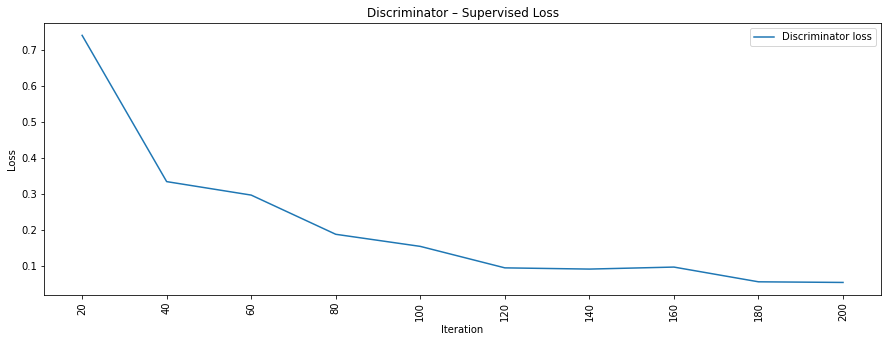

In [103]:
losses = np.array(supervised_losses)

# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

# visualization

In [104]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
# Necessary packages
from sklearn.manifold import TSNE

In [105]:
def visualization(ori_data, generated_data, analysis):
    """Using PCA or tSNE for generated and original data visualization.
    
    Args:
      - ori_data: original data
      - generated_data: generated synthetic data
      - analysis: tsne or pca
    """
    # Analysis sample size (for faster computation)
    anal_sample_no = min([1000, len(ori_data)])
    idx = np.random.permutation(len(ori_data))[:anal_sample_no]

    # Data preprocessing
    ori_data = np.asarray(ori_data)
    generated_data = np.asarray(generated_data)

    ori_data = ori_data[idx]
    generated_data = generated_data[idx]

    no, seq_len, dim= ori_data.shape 

    for i in range(anal_sample_no):
        if (i == 0):
            prep_data = np.reshape(np.mean(ori_data[0, :, :], 1), [1, seq_len])
            prep_data_hat = np.reshape(np.mean(generated_data[0, :, :], 1), [1, seq_len])
        else:
            prep_data = np.concatenate((prep_data,
                                        np.reshape(np.mean(ori_data[i, :, :], 1), [1, seq_len])))
            prep_data_hat = np.concatenate((prep_data_hat,
                                            np.reshape(np.mean(generated_data[i, :, :], 1), [1, seq_len])))

    # Visualization parameter        
    colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]

    if analysis == 'pca':
        # PCA Analysis
        pca = PCA(n_components=2)
        pca.fit(prep_data)
        pca_results = pca.transform(prep_data)
        pca_hat_results = pca.transform(prep_data_hat)

        # Plotting
        f, ax = plt.subplots(1)
        plt.scatter(pca_results[:, 0], pca_results[:, 1],
                    c=colors[:anal_sample_no], alpha=0.2, label="Original")
        plt.scatter(pca_hat_results[:, 0], pca_hat_results[:, 1],
                    c=colors[anal_sample_no:], alpha=0.2, label="Synthetic")

        ax.legend()
        plt.title('PCA plot')
        plt.xlabel('x-pca')
        plt.ylabel('y_pca')
        plt.show()

    elif analysis == 'tsne':

        # Do t-SNE Analysis together       
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis=0)

        # TSNE anlaysis
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
        tsne_results = tsne.fit_transform(prep_data_final)

        # Plotting
        f, ax = plt.subplots(1)

        plt.scatter(tsne_results[:anal_sample_no, 0], tsne_results[:anal_sample_no, 1],
                    c=colors[:anal_sample_no], alpha=0.2, label="Original")
        plt.scatter(tsne_results[anal_sample_no:, 0], tsne_results[anal_sample_no:, 1],
                    c=colors[anal_sample_no:], alpha=0.2, label="Synthetic")

        ax.legend()

        plt.title('t-SNE plot')
        plt.xlabel('x-tsne')
        plt.ylabel('y_tsne')
        plt.show() 

In [106]:
df_ori = pd.read_csv('./stock_data.csv')

In [107]:
print(df_ori.shape)
df_ori.head()

(555, 10)


,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/current-prefixes,v_/ports#link-tr-ssm-b-1-y/metrics/network-outgoing-bytes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries,v_/ports#link-intgw-exgw-a-3-x/metrics/network-outgoing-bytes-rate,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/total-entries,v_/devices#RR-01/power_state,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/drop-pkts,v_/ports#link-tr-intgw-a-3-x/metrics/network-incoming-bytes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/explicit-withdraw
0,1663761,7836,1.378144e+13,3114,1.197857e+06,7836,1,36485094,172993013.0,4
1,1663761,7836,1.378172e+13,3114,1.197857e+06,7836,1,36485094,172993795.0,4
2,1663761,7836,1.378200e+13,3114,1.211709e+06,7836,1,36485094,172994593.0,4
3,1663761,7836,1.378228e+13,3114,1.204602e+06,7836,1,36485094,172995277.0,4
4,1663761,7836,1.378255e+13,3114,1.197878e+06,7836,1,36485094,172995961.0,4


In [ ]:
import os

In [142]:
file_list = []
for filename in os.listdir('./'):
    if os.path.splitext(filename)[1] == '.csv' and os.path.splitext(filename)[0][:6] == 'sample':
        file_list.append(filename);
print(file_list)

['sample_119.csv', 'sample_179.csv', 'sample_199.csv', 'sample_159.csv', 'sample_139.csv']


In [143]:
df_list = []
for filename in file_list:
    df = pd.read_csv('./' + filename)
    df_list.append(df)

df_generator = pd.concat(df_list)

In [144]:
# df_generator = pd.read_csv('./sample_199.csv')
df_generator = df_generator.astype(int)

In [145]:
df_generator = df_generator.drop(columns = ['Unnamed: 0', 'v_type_code'])
print(df_generator.shape)
df_generator.head()

(500, 10)


,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/current-prefixes,v_/ports#link-tr-ssm-b-1-y/metrics/network-outgoing-bytes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries,v_/ports#link-intgw-exgw-a-3-x/metrics/network-outgoing-bytes-rate,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/total-entries,v_/devices#RR-01/power_state,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/drop-pkts,v_/ports#link-tr-intgw-a-3-x/metrics/network-incoming-bytes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/explicit-withdraw
0,1694549,7835,16249579000000,4318,1020485,7835,0,139630770,181967660,5
1,1692913,7835,16083345000000,4862,1167819,7835,0,135212540,181968130,6
2,1693015,7835,16171138000000,4319,904774,7835,1,132639870,181895700,7
3,1693951,7835,16292999000000,4639,824287,7835,0,131853070,181345980,6
4,1694196,7835,16066878000000,4763,1083130,7836,0,131500264,182300580,6


In [146]:
df_ori.describe()

,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/current-prefixes,v_/ports#link-tr-ssm-b-1-y/metrics/network-outgoing-bytes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries,v_/ports#link-intgw-exgw-a-3-x/metrics/network-outgoing-bytes-rate,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/total-entries,v_/devices#RR-01/power_state,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/drop-pkts,v_/ports#link-tr-intgw-a-3-x/metrics/network-incoming-bytes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/explicit-withdraw
count,5.550000e+02,555.000000,5.550000e+02,555.000000,5.550000e+02,555.000000,555.0,5.550000e+02,5.550000e+02,555.000000
mean,1.677326e+06,7835.909910,1.503697e+13,4485.843243,1.050576e+06,7835.909910,1.0,8.826516e+07,1.775301e+08,6.072072
std,1.130374e+04,0.286569,8.637625e+11,504.444784,3.010672e+05,0.286569,0.0,3.549553e+07,3.127299e+06,1.072395
min,1.663761e+06,7835.000000,1.378144e+13,3114.000000,0.000000e+00,7835.000000,1.0,3.648509e+07,1.729930e+08,4.000000
25%,1.668727e+06,7836.000000,1.441591e+13,4671.000000,8.991307e+05,7836.000000,1.0,6.276805e+07,1.753580e+08,6.000000
50%,1.673839e+06,7836.000000,1.504636e+13,4671.000000,1.208283e+06,7836.000000,1.0,8.796665e+07,1.776136e+08,6.000000
75%,1.686643e+06,7836.000000,1.567464e+13,4671.000000,1.215507e+06,7836.000000,1.0,1.151825e+08,1.797481e+08,7.000000
max,1.694401e+06,7836.000000,1.631167e+13,4671.000000,1.255915e+06,7836.000000,1.0,1.408380e+08,1.822764e+08,8.000000


In [147]:
df_generator.describe()

,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/current-prefixes,v_/ports#link-tr-ssm-b-1-y/metrics/network-outgoing-bytes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries,v_/ports#link-intgw-exgw-a-3-x/metrics/network-outgoing-bytes-rate,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/total-entries,v_/devices#RR-01/power_state,n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/drop-pkts,v_/ports#link-tr-intgw-a-3-x/metrics/network-incoming-bytes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/explicit-withdraw
count,5.000000e+02,500.000000,5.000000e+02,500.000000,5.000000e+02,500.000000,500.000000,5.000000e+02,5.000000e+02,500.000000
mean,1.691593e+06,7835.434000,1.606332e+13,4505.296000,1.110347e+06,7835.090000,0.170000,1.329113e+08,1.814535e+08,5.728000
std,1.983510e+03,0.496121,1.644157e+11,260.451689,1.605729e+05,0.286468,0.376009,6.387096e+06,5.994843e+05,0.592214
min,1.688355e+06,7835.000000,1.581086e+13,4138.000000,7.758180e+05,7835.000000,0.000000,1.208426e+08,1.802753e+08,5.000000
25%,1.689848e+06,7835.000000,1.592367e+13,4275.000000,9.696650e+05,7835.000000,0.000000,1.276611e+08,1.809417e+08,5.000000
50%,1.691423e+06,7835.000000,1.604651e+13,4437.500000,1.146426e+06,7835.000000,0.000000,1.331476e+08,1.815253e+08,6.000000
75%,1.693278e+06,7836.000000,1.620546e+13,4754.750000,1.252066e+06,7835.000000,0.000000,1.389407e+08,1.819687e+08,6.000000
max,1.695531e+06,7836.000000,1.636608e+13,4966.000000,1.341591e+06,7836.000000,1.000000,1.426989e+08,1.824384e+08,7.000000


/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/pan

array([[<AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/total-entries'}>],
       [<AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/current-prefixes'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/explicit-withdraw'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/drop-pkts'}>],
       [<AxesSubplot:title={'center':'v_/devices#R

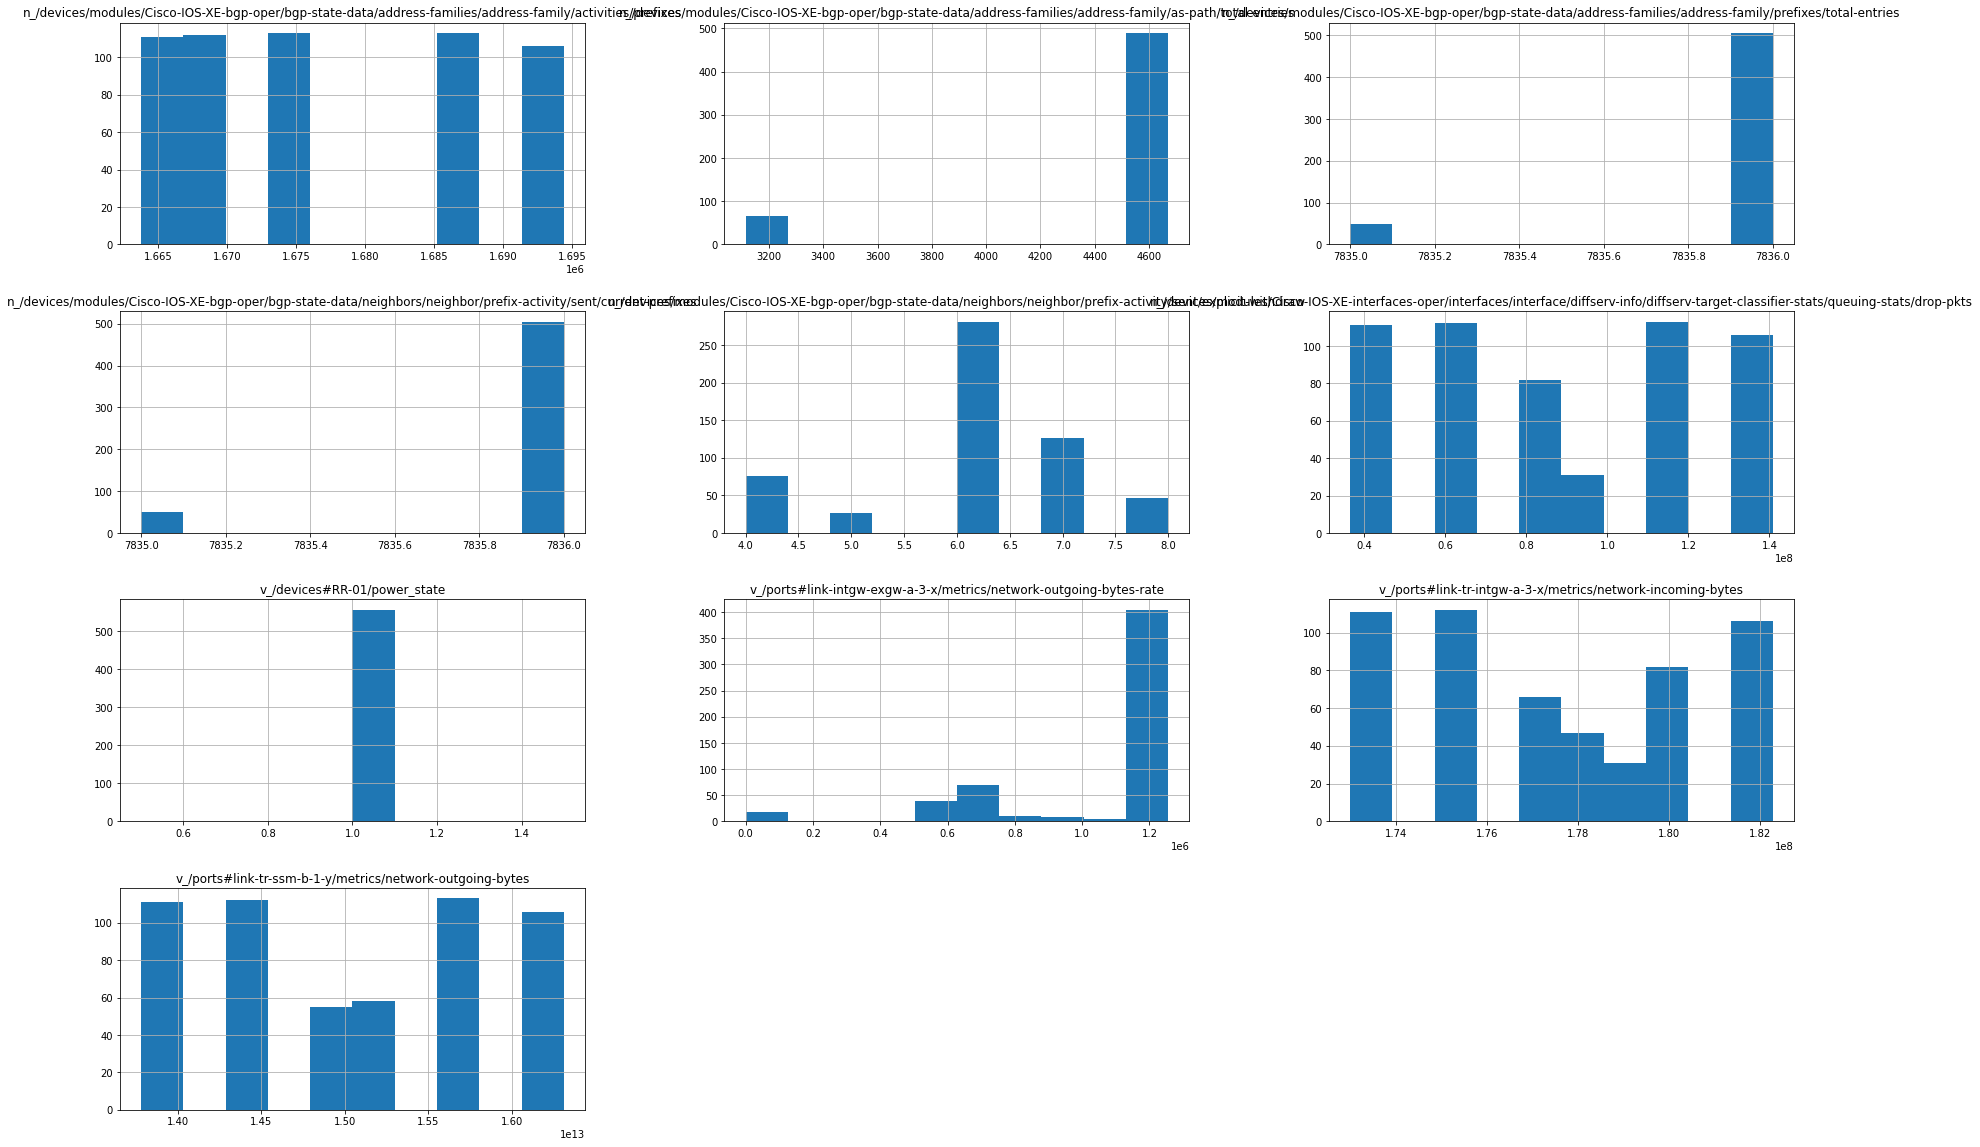

In [148]:
df_ori.hist(figsize=(30,20))

array([[<AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/prefixes/total-entries'}>],
       [<AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/current-prefixes'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/neighbors/neighbor/prefix-activity/sent/explicit-withdraw'}>,
        <AxesSubplot:title={'center':'n_/devices/modules/Cisco-IOS-XE-interfaces-oper/interfaces/interface/diffserv-info/diffserv-target-classifier-stats/queuing-stats/drop-pkts'}>],
       [<AxesSubplot:title={'center':'v_/devices#R

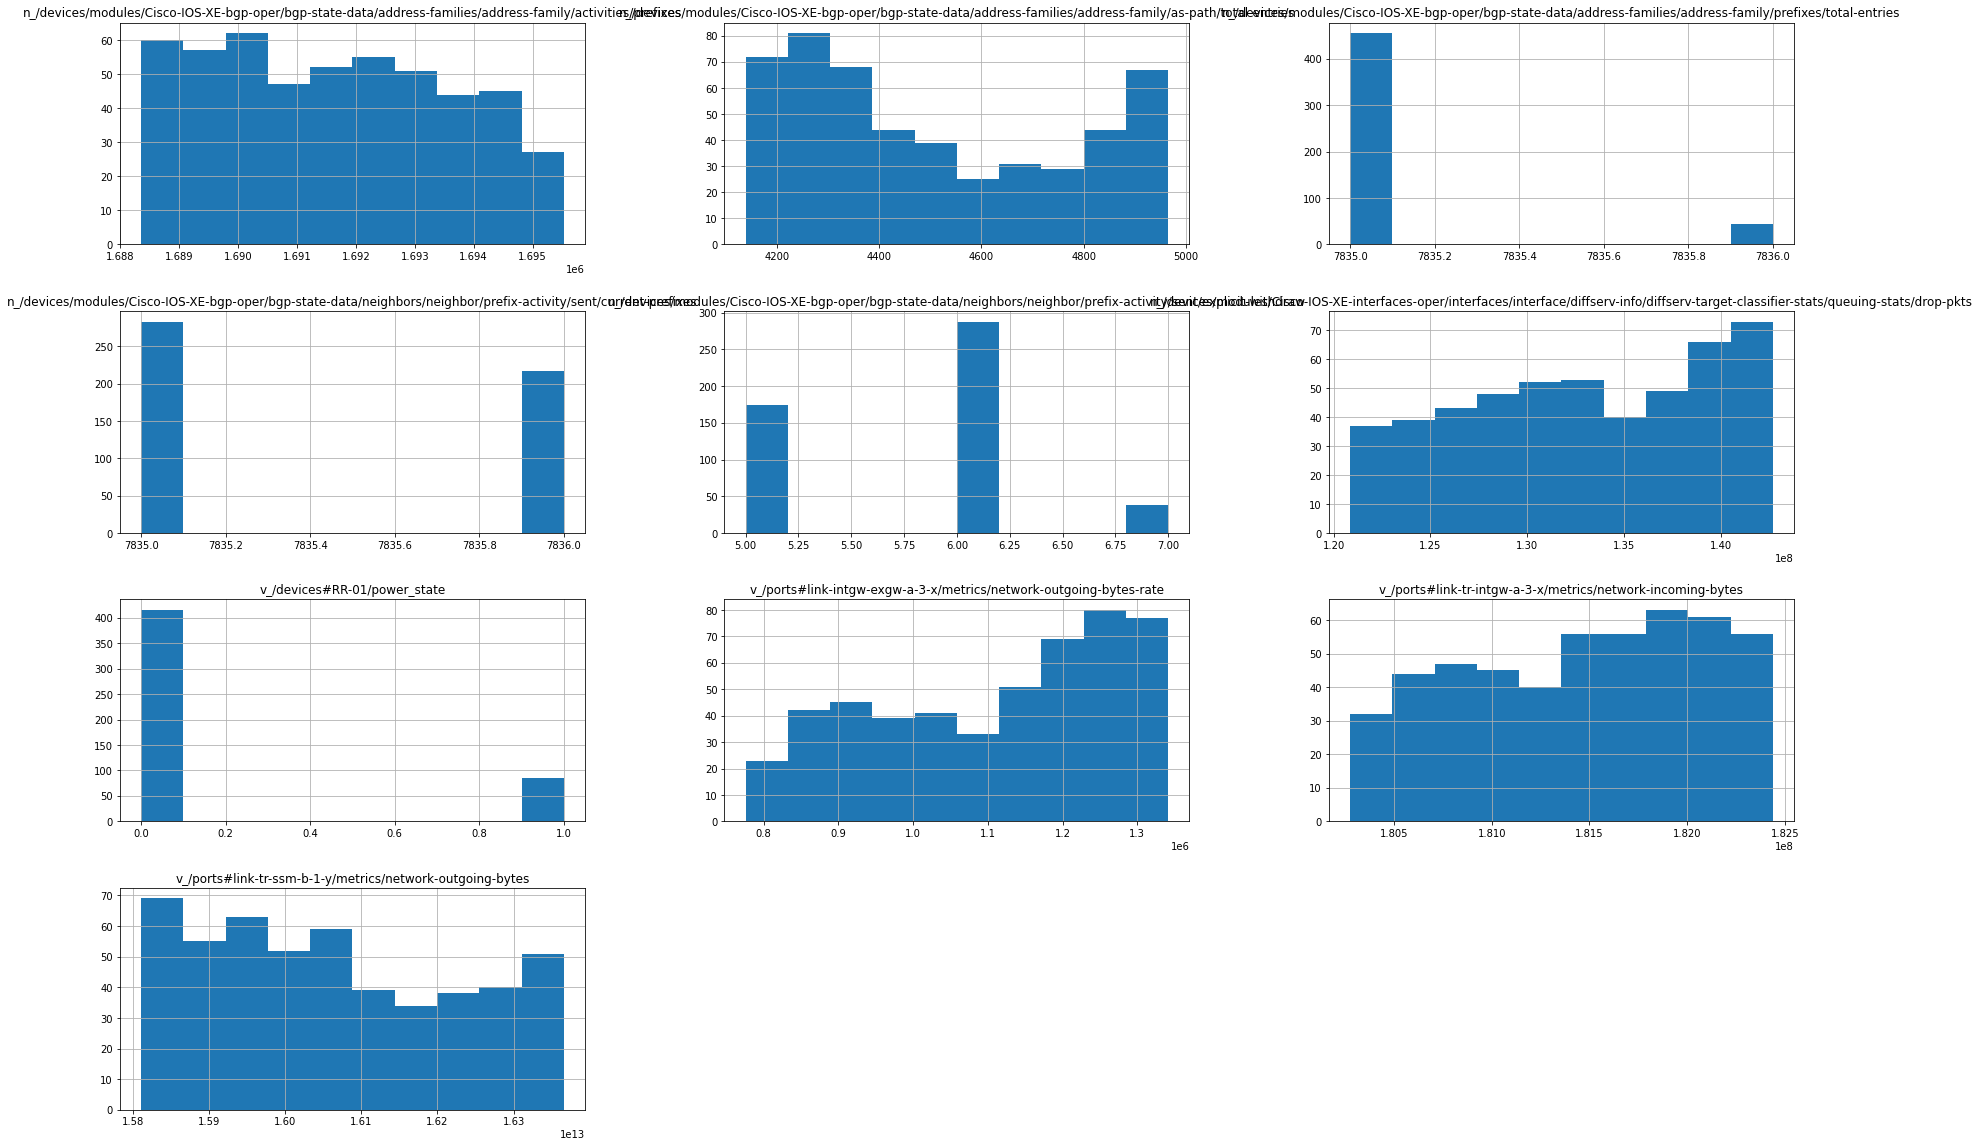

In [149]:
df_generator.hist(figsize=(30,20))

In [150]:
v_df_ori = df_ori.values.reshape(-1, 5, 10)
v_df_generator = df_generator.values.reshape(-1, 5, 10)

In [153]:
print(v_df_ori.shape, v_df_generator.shape)

(111, 5, 10) (100, 5, 10)


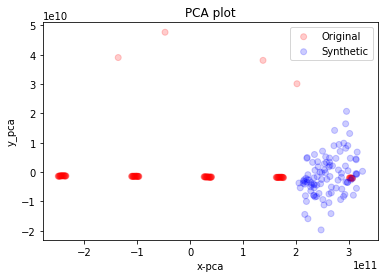

In [154]:
visualization(v_df_ori[:100], v_df_generator, 'pca')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 934354729.642032
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.894012
[t-SNE] KL divergence after 300 iterations: 0.169896


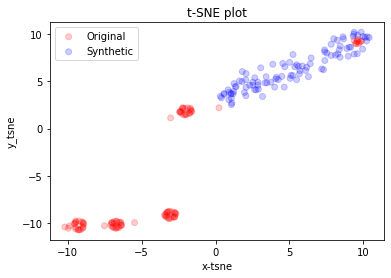

In [156]:
visualization(v_df_ori[:100], v_df_generator, 'tsne')

# Diff dataset

In [115]:
def get_diff_dataset2(dataset, X_train):
    diff_dataset = pd.DataFrame(columns=dataset.columns)
    cur_type = 0
    start_index = 6

    for index, row in dataset.iterrows():
        if index < 6:
            pass

        row_type = row[-1]
        if index == dataset.shape[0] - 1:
            # last line
            end_index = index
            diff_df = X_train.loc[[start_index-1, end_index]].diff().loc[[end_index]]
            diff_df['v_type_code'] = cur_type
            diff_dataset = diff_dataset.append(diff_df, ignore_index=True, sort=False)

        elif row_type != cur_type:
            end_index = index - 1
            diff_df = X_train.loc[[start_index-1, end_index]].diff().loc[[end_index]]
            diff_df['v_type_code'] = cur_type
            diff_dataset = diff_dataset.append(diff_df, ignore_index=True, sort=False)
            # new start
            start_index = index
            cur_type = row_type

    diff_dataset['v_type_code'] = pd.to_numeric(diff_dataset['v_type_code'])
    return diff_dataset

In [119]:
dataset_path = './sample_2799.csv'
diff_dataset_path = './diff_sample_2799.csv'

dataset = pd.read_csv(dataset_path)
print('dataset', dataset.shape)
# Segmentation training tests
column = dataset.columns
X_train = dataset[column[:-1]]
y_train = dataset[column[-1]]

print('get diff dataset...')
diff_dataset = get_diff_dataset2(dataset, X_train)

print('writing to csv..')
diff_dataset.to_csv(diff_dataset_path)
print('diff_dataset:', diff_dataset.shape)

dataset (1000, 661)
get diff dataset...


/Users/xiafei/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


writing to csv..
diff_dataset: (193, 661)


In [120]:
dataset.head()

,Unnamed: 0,p_/computes0/service/id,p_/computes0/vcpus_used,p_/computes0/vcpus,p_/computes0/memory_mb_used,p_/computes0/memory_mb,p_/computes0/cpu_info/topology/cores,p_/computes0/cpu_info/topology/cells,p_/computes0/cpu_info/topology/threads,p_/computes0/cpu_info/topology/sockets,...,v_/ports#link-tr-tr-a-1-x/metrics/network-outgoing-packets-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-bytes,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-rate,v_type_code
0,0,15.001137,20.999386,47.000404,41473.000,257791.0,12.999881,2.999250,2.999397,1.999730,...,-3.782104,241061090.0,4893.9897,1507168.6,-3.842875,240655740.0,2663.7078,1374223.9,2.347688,3.0
1,1,15.000092,20.998756,47.000492,41471.000,257789.0,11.001966,2.998003,2.999530,0.000137,...,-3.847382,246739500.0,-4688.0400,1506730.5,-3.843635,242009390.0,2665.4167,1359227.8,2.347825,3.0
2,2,16.998695,19.000420,48.999844,41471.000,257791.0,12.999615,2.994805,2.996756,0.006095,...,-1.113025,230728800.0,-4437.8030,1507347.5,1.402934,241031300.0,2662.8992,1374370.4,-1.318525,3.0
3,3,15.006442,20.997887,47.000420,41473.000,257791.0,11.001045,2.999379,2.999726,0.000603,...,-2.900382,235586780.0,4147.1587,1507345.2,-3.725357,242103860.0,2663.1018,1373355.6,-1.819487,3.0
4,4,15.000463,19.000256,48.994957,41471.004,257789.0,11.001375,2.997632,2.998675,1.999826,...,-3.844071,245031800.0,-4686.3394,1506923.2,-3.843395,234390700.0,-1156.4761,1374409.1,2.349252,3.0
